<a href="https://colab.research.google.com/github/cpyp-ipdp/pgd_cdmx/blob/main/indicadores/educacion_ciencia/indicadores_educ_ciencia_tec_pgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
##Estimación de indicadores de vivienda
#Se borra todo lo que se encuentra en el entorno

rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, showtext, srvyr,googledrive,haven)

Loading required package: pacman



In [14]:
#Crear directorio para guardar los archivos
dir.create("data", showWarnings = FALSE)

In [ ]:
url_basica<-"https://www.inegi.org.mx/contenidos/programas/enigh/nc/"
segunda_parte<-"microdatos/enigh"
fin1<-"_ns_"
fin2<-"_csv.zip"

In [ ]:
years<-c("2016", "2018", "2020", "2022")

In [ ]:
# Función genérica para descargar, descomprimir, renombrar y eliminar
procesar_archivo <- function(year, tipo, url_base, segunda_parte, fin1, fin2, carpeta_destino) {
  # Construir URL y ruta de destino
  url <- paste0(url_base, year, "/", segunda_parte, year, fin1, tipo, fin2)
  destfile <- paste0(carpeta_destino, "/", year, fin1, tipo, fin2)

  # Descargar el archivo
  download.file(url, destfile = destfile)

  # Descomprimir el archivo
  unzip(destfile, exdir = carpeta_destino)

  # Renombrar el archivo descomprimido
  file.rename(
    from = paste0(carpeta_destino, "/", tipo, ".csv"),
    to = paste0(carpeta_destino, "/", tipo, "_", year, ".csv")
  )

  # Eliminar el archivo descargado
  file.remove(destfile)
}

In [ ]:
# Iterar sobre los años y procesar cada tipo de archivo
for (i in 1:length(years)) {
  procesar_archivo(years[i], "poblacion", url_basica, segunda_parte, fin1, fin2, "data")
  procesar_archivo(years[i], "viviendas", url_basica, segunda_parte, fin1, fin2, "data")
}

#### Función de estimación

In [ ]:
estimacion <- function(path, variable) {
      # Cargar los datos de población
  datos <- read_csv(path, show_col_types = FALSE)

  # Si son datos de 2016 a 2020, unir con la tabla de viviendas
  if (substr(path, 16, 19) %in% c("2016", "2018", "2020")) {
    # Cargar tabla viviendas
    vivienda <- read_csv(str_replace(path, "poblacion", "viviendas"), show_col_types = FALSE)

    # Pegar factor, upm y est_dis de la tabla vivienda
    datos <- datos %>%
      left_join(vivienda %>% select(folioviv, factor, upm, est_dis), by = "folioviv")
  }

  # Cargar los datos
  datos <- datos %>%
    mutate(cve_ent = case_when(
      nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
      nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    )) %>%
    # Filtrar si entidad es 9
  filter(cve_ent == "09")


  # Definir diseño muestral
  mydesign <- datos %>%
    as_survey_design(ids = upm,
                     strata = est_dis,
                     weights = factor)


###Estimaciones###
  # Población de 6 a 14 años que asiste a la escuela
  asistencia <- mydesign %>%
filter(edad >= 6 & edad <= 14)%>%
    group_by(asis_esc) %>%
    summarise(
      personas = survey_total(vartype = "cv"),
      porcentaje = survey_prop(vartype = "cv")
    ) %>%
    mutate(porcentaje = round(porcentaje * 100, 2)) %>%
    filter(asis_esc == 1) %>%
    # Añadir año
    mutate(year = substr(path, 16, 19))


#Población mayor a 3 años analfabeta
    analfabetismo <- mydesign %>%
filter(edad>3)%>%
        group_by(alfabetism) %>%
        summarise(
        personas = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
        ) %>%
        mutate(porcentaje = round(porcentaje * 100, 2)) %>%
        filter(alfabetism == 2) %>%
        # Añadir año
        mutate(year = substr(path, 16, 19))



##Grado promedio de escolaridad
        gradoprom<-mydesign%>%
filter(!is.na(nivelaprob))%>%
    filter(nivelaprob>=2)%>%
#Filtrar 15 años y más
    filter(edad>=15)%>%
#Calcular años de escolaridad según nivel y grados aprobados
    mutate(
        anos_escolaridad=
        case_when(
            #Primaria
            nivelaprob==2 ~ gradoaprob,
            #Secundaria
            nivelaprob==3 ~ gradoaprob+6,
            #Preparatoria
            nivelaprob==4 ~ gradoaprob+9,
#Licenciatura, normal o carrera técnica
            nivelaprob %in% c(5,6,7) ~ gradoaprob+12,
#Posgrado (nivelaprob 8,9)
            nivelaprob %in% c(8,9) ~ gradoaprob+17
        )


    )%>%
    summarise(
        promedio_escolaridad=survey_mean(anos_escolaridad,na.rm = TRUE, vartype = "cv")
    )%>%
    mutate(year=substr(path,16,19))






  # Devolver el resultado basado en la variable
  if (variable == "asistencia_escolar") {
    return(asistencia)
  }
    else if (variable == "analfabetismo") {
    return(analfabetismo)
    }
    else if (variable == "grado_escolaridad") {
    return(gradoprom)
    }
else {
    stop("Variable no reconocida. Use 'rezago' o 'sin_escrituras'.")
  }

}


### Indicadores educativos
#### Porcentaje de población de 6 a 14 años que asiste a la escuela

In [ ]:
tabla_asistencia<-map_dfr(
  list.files("data", full.names = TRUE,pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "asistencia_escolar"
)
print("Porcentaje de población de 6 a 14 años que asiste a la escuela")
tabla_asistencia

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


asis_esc,personas,personas_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1174501,0.04769559,99.11,0.003358606,2016
1,1134481,0.04667804,98.98,0.005532614,2018
1,1022955,0.04437516,97.91,0.005801212,2020
1,1050982,0.04475938,98.79,0.003823138,2022


#### Porcentaje de población mayor a 3 años analfabeta

In [ ]:
tabla_analfabetismo<-map_dfr(
  list.files("data", full.names = TRUE,pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "analfabetismo"
)
print("Porcentaje de población mayor a 3 años analfabeta")
tabla_analfabetismo

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "Porcentaje de población mayor a 3 años analfabeta"


alfabetism,personas,personas_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,392513,0.07218314,4.48,0.06826306,2016
2,385054,0.06821630,4.33,0.06324768,2018
2,362758,0.06924958,4.05,0.06339509,2020
2,318218,0.07606005,3.50,0.07296126,2022



#### Grado promedio de escolaridad

In [ ]:
tabla_gradoprom<-map_dfr(
  list.files("data", full.names = TRUE,pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "grado_escolaridad"
)
print("Grado promedio de escolaridad de la población de 15 años y más")
tabla_gradoprom

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "Grado promedio de escolaridad de la población de 15 años y más"


promedio_escolaridad,promedio_escolaridad_cv,year
<dbl>,<dbl>,<chr>
11.56641,0.007964465,2016
11.67076,0.007571768,2018
11.76720,0.006940187,2020
11.95221,0.006589243,2022


#### Tasa de cobertura de educación primaria, secundaria y media superior

Para calcular estas tasas se utilizan los datos de las matrículas reportadas por la SEP y las proyecciones de población de CONAPO. La tasa de cobertura se calcula como la matrícula reportada por la SEP por tipo de educación dividida entre la población proyectada por CONAPO por rango de edad que tradicionalmente corresponde a cada tipo de educación.

In [67]:
##Leer datos de proyecciones de población de CONAPO

conapo<-read_csv("https://conapo.segob.gob.mx/work/models/CONAPO/Datos_Abiertos/pry23/00_Pob_Mitad_1950_2070.csv")%>%
  janitor::clean_names()%>%
  filter(cve_geo==9)%>%
group_by(ano,edad)%>%
    summarise(poblacion= sum(poblacion))%>%
mutate(tipo=
case_when(edad>=6 & edad<=11 ~ "PRIMARIA TOTAL",
          edad>=12 & edad<=14 ~ "SECUNDARIA TOTAL",
            edad>=15 & edad<=17 ~ "MEDIA SUPERIOR"
            )
)%>%
#Eliminar si tipo es NA
filter(!is.na(tipo))%>%
group_by(ano,tipo)%>%
summarise(poblacion=sum(poblacion))


head(conapo)

Rows: 737660 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): ENTIDAD, SEXO
dbl (5): RENGLON, AÑO, CVE_GEO, EDAD, POBLACION

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'ano'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'ano'. You can override using the `.groups`
argument.


ano,tipo,poblacion
<dbl>,<chr>,<dbl>
1970,MEDIA SUPERIOR,469921
1970,PRIMARIA TOTAL,1133443
1970,SECUNDARIA TOTAL,505690
1971,MEDIA SUPERIOR,486252
1971,PRIMARIA TOTAL,1161388
1971,SECUNDARIA TOTAL,519472


In [68]:
##Leer datos de SEP

sep<-openxlsx::read.xlsx("https://www.planeacion.sep.gob.mx/Doc/estadistica_e_indicadores/serie_historica_entidades_sep.xlsm",sheet = 1)%>%
janitor::clean_names()%>%
  { 
    colnames(.) <- as.character(.[2, ])
    .[-2, ]
  } %>%
  as.data.frame()%>%
janitor::clean_names()%>%
  rename(entidad = 1,
         tipo=3
         )%>%
filter(entidad=="9")%>%
filter(tipo=="PRIMARIA TOTAL" | tipo=="SECUNDARIA TOTAL" | tipo=="MEDIA SUPERIOR")%>%
#Eliminar columnas 1,2 y 4
select(-c(1,2,4))%>%
#Llevar los datos a long
pivot_longer(cols = -c(tipo), names_to = "ciclo", values_to = "matricula")%>%
#Eliminar x de ciclo
mutate(ciclo=str_replace(ciclo,"x",""),
#Seleccionar año inicial del ciclo
ano=as.numeric(str_sub(ciclo,1,4)),
matricula=as.numeric(matricula))%>%
#Pegar con datos de CONAPO utilizando la variable tipo y ano
left_join(conapo,by=c("tipo","ano"))%>%
#Calcular tasa de cobertura
mutate(tasa_cobertura=matricula/poblacion*100)

In [56]:
#Mostrar las tablas por tipo de educación y año

for (i in unique(sep$tipo)) {
  cat("Tasa de cobertura de", i, "\n")
  sep %>%
    filter(tipo == i) %>%
    mutate(tasa_cobertura = format(round(tasa_cobertura, 2), nsmall = 2)) %>%
    select(ano, tasa_cobertura) %>%
    print(n = Inf)
  cat("\n")
}


Tasa de cobertura de PRIMARIA TOTAL 
# A tibble: 41 × 2
     ano tasa_cobertura
   <dbl> <chr>         
 1  1990 109.81        
 2  1991 109.40        
 3  1992 107.76        
 4  1993 108.37        
 5  1994 108.85        
 6  1995 108.55        
 7  1996 108.03        
 8  1997 107.98        
 9  1998 107.89        
10  1999 107.74        
11  2000 107.38        
12  2001 107.26        
13  2002 107.41        
14  2003 107.43        
15  2004 106.70        
16  2005 107.45        
17  2006 107.61        
18  2007 108.16        
19  2008 109.12        
20  2009 110.36        
21  2010 112.31        
22  2011 114.91        
23  2012 114.99        
24  2013 115.45        
25  2014 113.81        
26  2015 115.76        
27  2016 113.67        
28  2017 112.19        
29  2018 110.69        
30  2019 110.13        
31  2020 110.16        
32  2021 111.36        
33  2022 110.52        
34  2023 111.03        
35  2024 111.14        
36  2025 111.46        
37  2026 111.98        
38  2027

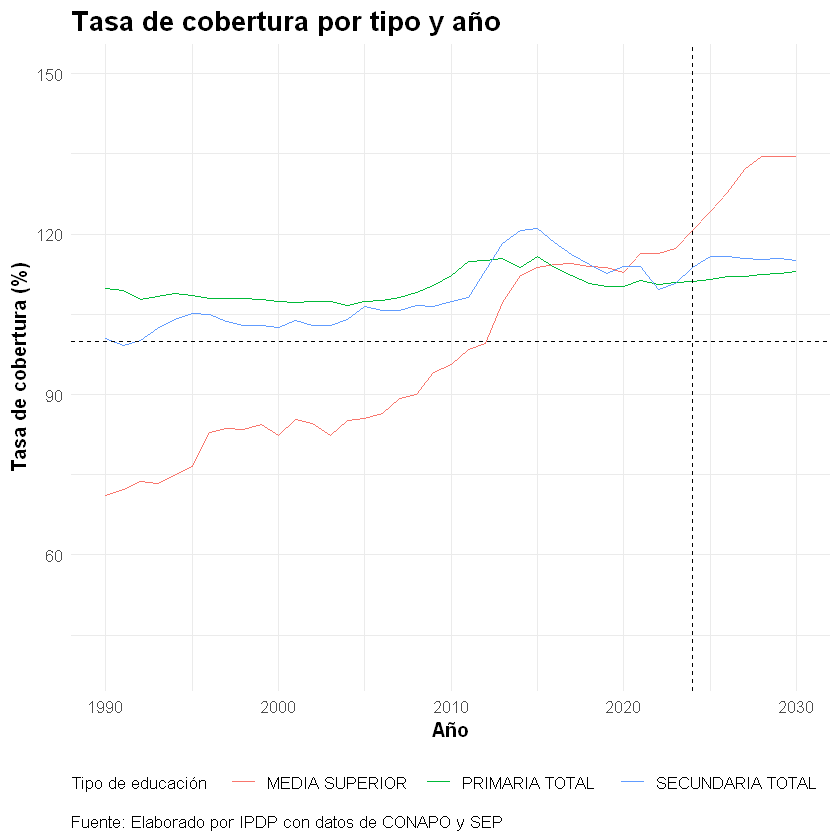

In [70]:
#Crear gráficas de tasas de cobertura por tipo y año
ggplot(sep,aes(x=ano,y=tasa_cobertura,color=tipo))+
geom_line()+
theme_minimal()+
#Eje y que inicie en 20
scale_y_continuous(limits=c(40,150))+
#Línea en 2024
geom_vline(xintercept=2024,linetype="dashed")+
#Línea horizontal en 100
geom_hline(yintercept=100,linetype="dashed")+
labs(title="Tasa de cobertura por tipo y año",x="Año",y="Tasa de cobertura (%)",
        color="Tipo de educación",
        caption="Fuente: Elaborado por IPDP con datos de CONAPO y SEP")+
theme(plot.title = element_text(hjust = 0, size=16, face="bold"),
    
        plot.caption = element_text(hjust = 0, size=10),
      axis.title = element_text(size=12, face="bold"),
      axis.text = element_text(size=10),
      legend.title = element_text(size=10),
      legend.text = element_text(size=10),
        legend.position = "bottom")

#Salvar gráfica
ggsave("tasa_cobertura_educacion.png",width=10,height=6,dpi=300,bg="white")


#### Porcentaje de población en pobreza por rezago educativo

In [15]:
  #Conectar a google drive
drive_auth(email = "claudiodanielpc@gmail.com",cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=aeac4526bbef34c54aefa9b71442f263&login_hint=claudiodanielpc%40gmail.com&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQVNWZ2kzS2wzZUxmQUpsLVRpNWhNazd3YWV6bkZLaHR1Tm5nQ1JsTy1yUUpONW02cEtJRFVkQU5iVkpQMmhJN0RnT3ZrZyIsInN0YXRlIjoiYWVhYzQ1MjZiYmVmMzRjNTRhZWZhOWI3MTQ0MmYyNjMifQ==


In [16]:
carpeta<-as_id(drive_get("https://drive.google.com/drive/folders/1TBfoik4w4DWhwFqWeZFgkZvrBdDbqzku"))


archivos<-drive_ls(carpeta)
print(archivos)

# A dribble: 3 × 3
  name             id                                drive_resource   
  <chr>            <drv_id>                          <list>           
1 pobreza_2022.dta 1T_WfYanYMOoWWbhj_CeiqxYRNrpXmDan <named list [42]>
2 pobreza_2020.dta 1TXJLNA_itWfjsGIdoj1bJQ4erNjc1wIx <named list [42]>
3 pobreza_2018.dta 1TTRfiRDGWgQwHylvduHx1IRdm5vQ3VeL <named list [42]>


In [19]:
estimacion_pobreza <- function(file_id, file_name) {
  # Descarga de datos
  local_path <- file.path("data", file_name)
  drive_download(as_id(file_id), path = local_path, overwrite = TRUE)

  # Leer datos
  datos <- read_dta(local_path)

  # Añadir año
  year <- str_extract(file_name, "\\d{4}")


  # Diseño muestral
  mydesign <- datos %>%
    as_survey_design(ids = upm,
                     strata = est_dis,
                     weights = factor)

  # Estima pobreza
  pobreza <- mydesign %>%
    #Filtrar datos para CDMX
  filter(entidad==9)%>%
group_by(pobreza_rei)%>%
    #Filtar grupo de población en pobreza

    summarise(
      poblacion = survey_total(vartype = "cv"),
      porcentaje = survey_prop(vartype = "cv")
    ) %>%
    mutate(porcentaje = round(porcentaje * 100, 2),
           year = as.numeric(year))%>%
filter(pobreza_rei == 1)

  return(pobreza)
}

In [20]:
tabla_pobreza <- map_dfr(
  seq_len(nrow(archivos)),
  ~ estimacion_pobreza(archivos$id[.x], archivos$name[.x])
)%>%
  arrange(year)

print("Porcentaje de población en pobreza por rezago educativo")
tabla_pobreza

File downloaded:

• pobreza_2022.dta <id: 1T_WfYanYMOoWWbhj_CeiqxYRNrpXmDan>

Saved locally as:

• data/pobreza_2022.dta

File downloaded:

• pobreza_2020.dta <id: 1TXJLNA_itWfjsGIdoj1bJQ4erNjc1wIx>

Saved locally as:

• data/pobreza_2020.dta

File downloaded:

• pobreza_2018.dta <id: 1TTRfiRDGWgQwHylvduHx1IRdm5vQ3VeL>

Saved locally as:

• data/pobreza_2018.dta



[1] "Porcentaje de población en pobreza por rezago educativo"


pobreza_rei,poblacion,poblacion_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2338591,0.03957730,25.43,0.03024622,2018
1,2233119,0.03768032,24.17,0.03081337,2020
1,2225816,0.03786385,23.92,0.03114584,2022


#### Porcentaje de presupuesto aprobado para innovación, ciencia y tecnoogía respecto del total

In [48]:
##Hacer lista con urls de los archivos

presupuestos <- list(
  '2024' = 'https://datos.cdmx.gob.mx/dataset/3a6cba97-adb1-4f35-9df1-984cc3657aca/resource/7fa1da81-531c-477c-93db-7580bc1c7ad0/download/egresos_2024_aprobado.csv',
  '2023' = 'https://datos.cdmx.gob.mx/dataset/ea119a03-4f5a-46fa-afbe-bc32bcf79ec3/resource/5137e3db-227e-462d-8d59-1942afbc0c6a/download/egresos_2023_aprobado.csv',
  '2022' = 'https://datos.cdmx.gob.mx/dataset/755f47f1-b937-4131-8a7b-fbe306e747c8/resource/fc93c940-ad75-4e7f-afe6-c624726623a9/download/egresos_2022_aprobado.csv',
  '2021' = 'https://datos.cdmx.gob.mx/dataset/246be014-62ba-46e0-a7ce-9f37c8f01886/resource/682c37bd-96a2-4f78-94bf-3c77c3870f04/download/egresos_2021_aprobado.csv',
  '2020' = 'https://datos.cdmx.gob.mx/dataset/2bb4de63-8212-4d2a-a377-98b10f8384c6/resource/def0fc56-4e26-4cd2-9ec6-200cb86b418e/download/egresos_2020_aprobado.csv',
  '2019' = 'https://datos.cdmx.gob.mx/dataset/8dc52617-63f6-4bfd-9fae-54239675c6d0/resource/9a6f53d7-1751-4ae4-8bd8-d31807be7789/download/egresos_2019_aprobado.csv',
  '2018' = 'https://datos.cdmx.gob.mx/dataset/7a8820f2-3bea-4c69-8b20-1d01b1a99a6a/resource/5b20655c-072f-4347-baee-ab93d930b27b/download/egresos_2018_aprobado.csv'
)


In [49]:
##Concentrar archivos en una sola tabla

presupuestos <- map_dfr(
  names(presupuestos),
  ~ read_csv(presupuestos[[.x]],show_col_types = FALSE)%>%
    mutate(year = as.numeric(.x))%>%
#Identificar presupuesto de innovación, ciencia y tecnología
mutate(ict=case_when((funcion==38) ~ 1, TRUE ~ 0))
)

In [53]:
#Funciones y subfunciones presupuestales
print(paste0("Funciones presupuestales: ", unique(presupuestos$desc_funcion[presupuestos$ict==1])))
print(paste0("Claves de funciones presupuestales: ", unique(presupuestos$funcion[presupuestos$ict==1])))
print(paste0("Subfunciones presupuestales: ", unique(presupuestos$subfuncion[presupuestos$ict==1])))
print(paste0("Subfunciones presupuestales: ", unique(presupuestos$desc_subfuncion[presupuestos$ict==1])))

[1] "Funciones presupuestales: Ciencia, Tecnología e Innovación"      
[2] "Funciones presupuestales: Ciencia, Tecnolog\xeda e Innovaci\xf3n"
[1] "Claves de funciones presupuestales: 38"
[1] "Subfunciones presupuestales: 384" "Subfunciones presupuestales: 381"
[3] "Subfunciones presupuestales: 383" "Subfunciones presupuestales: 382"
[1] "Subfunciones presupuestales: Innovación"                          
[2] "Subfunciones presupuestales: Investigación Científica"            
[3] "Subfunciones presupuestales: Innovaci\xf3n"                       
[4] "Subfunciones presupuestales: Servicios Científicos y Tecnológicos"
[5] "Subfunciones presupuestales: Desarrollo Tecnológico"              


In [56]:
#Calcular porcentaje de presupuesto aprobado para ICT respecto del total por año
tabla_cienciatec<-presupuestos %>%
  group_by(year) %>%
  summarise(
    aprobado = sum(monto_aprobado),
    monto_ict = sum(monto_aprobado[ict == 1]),
    porcentaje = monto_ict / aprobado * 100
  ) %>%
  arrange(year)
tabla_cienciatec

year,aprobado,monto_ict,porcentaje
<dbl>,<dbl>,<dbl>,<dbl>
2018,226851897840,350824762,0.15464925
2019,234016325579,359279543,0.15352756
2020,238974793216,406148625,0.16995459
2021,217962157170,146634666,0.06727529
2022,234005875723,65365439,0.02793325
2023,248415083383,263752539,0.10617412
2024,267965350437,325495931,0.12146941


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


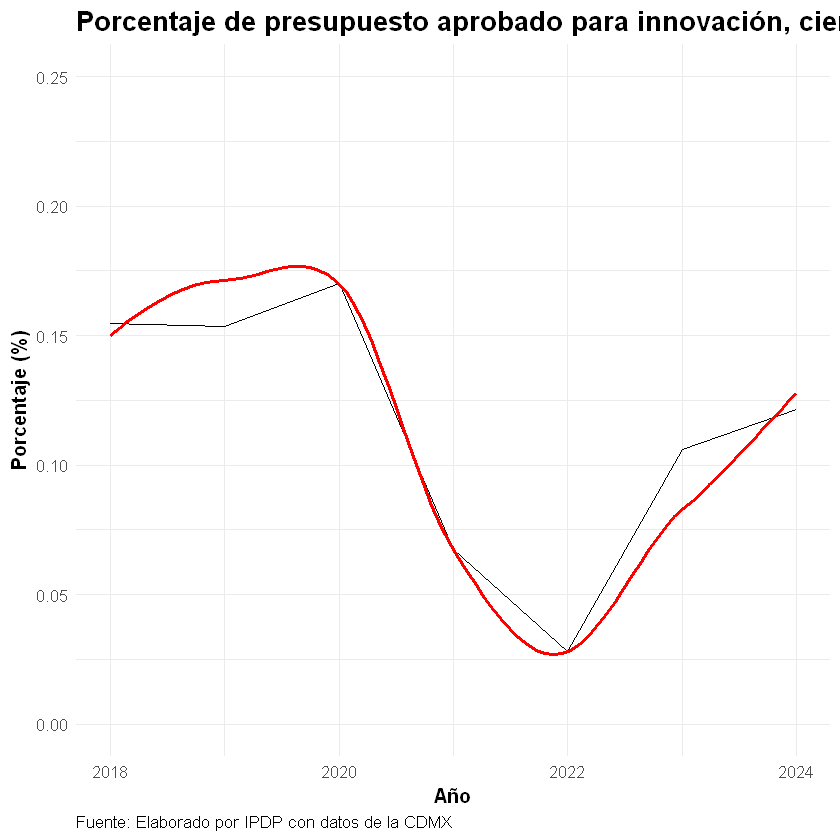

In [63]:
#Crear gráfica
ggplot(tabla_cienciatec, aes(x = year, y = porcentaje)) +
  geom_line() +
  geom_smooth(method = "loess", se = FALSE, color = "red") +
scale_y_continuous(limits=c(0,0.25))+
  labs(title = "Porcentaje de presupuesto aprobado para innovación, ciencia y tecnología respecto del total, 2018-2024",
       x = "Año",
       y = "Porcentaje (%)",
       caption = "Fuente: Elaborado por IPDP con datos de la CDMX") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0, size = 16, face = "bold"),
        plot.caption = element_text(hjust = 0, size = 10),
        axis.title = element_text(size = 12, face = "bold"),
        axis.text = element_text(size = 10),
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 10),
        legend.position = "none")

#Salvar gráfica
ggsave("porcentaje_cienciatec.png", width = 10, height = 6, dpi = 300, bg = "white")

#### Porcentaje de solicitudes de patentes de mexicanos en la Ciudad de México respecto del total

In [139]:
impi <- read_csv("https://datosabiertos.impi.gob.mx/IMPICifras/Invenciones03.csv", 
                 col_names = FALSE, show_col_types = FALSE)


impi <- impi %>%
  slice(5:n()) %>%                             
  set_names(as.character(impi[5, ])) %>%       
  janitor::clean_names() %>%                   
  slice(-1)%>%
rename(entidad=2)%>%
filter(entidad=="Ciudad de México" | entidad=="Total / Total")%>%
#Dejar columna entidad y todas aquellas que contengan "patentes"
select(entidad,contains("patentes"))%>%
#Transformar columnas patentes a numérico
#Eliminar comas de los números
mutate(across(contains("patentes"), ~ as.numeric(str_replace_all(., ",", ""))) )%>%

# #Calcular porcentaje de patentes diviendo entidad "Ciudad de México" entre "Total / Total"
  # Calculate percentages for columns containing 'patentes'
mutate(across(contains("patentes"), ~ . / .[entidad == "Total / Total"] * 100))%>%
filter(entidad=="Ciudad de México")%>%
# #Long
pivot_longer(cols = -entidad, names_to = "tipo", values_to = "porcentaje")%>%
# #Crear variable año de 1993 hasta que se terminan las columnas
mutate(year = 1993:(1993 + n() - 1)) %>%
filter(year <= 2020 | (year > 2020 & (year - 2020) %% 5 == 0))%>%
mutate(year = 1993:(1993 + n() - 1))
impi

entidad,tipo,porcentaje,year
<chr>,<chr>,<dbl>,<int>
Ciudad de México,patentes_patents,48.82459,1993
Ciudad de México,patentes_patents_2,42.36948,1994
Ciudad de México,patentes_patents_3,46.06481,1995
Ciudad de México,patentes_patents_4,40.67358,1996
Ciudad de México,patentes_patents_5,37.61905,1997
Ciudad de México,patentes_patents_6,40.17660,1998
Ciudad de México,patentes_patents_7,40.21978,1999
Ciudad de México,patentes_patents_8,38.97912,2000
Ciudad de México,patentes_patents_9,40.44944,2001


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


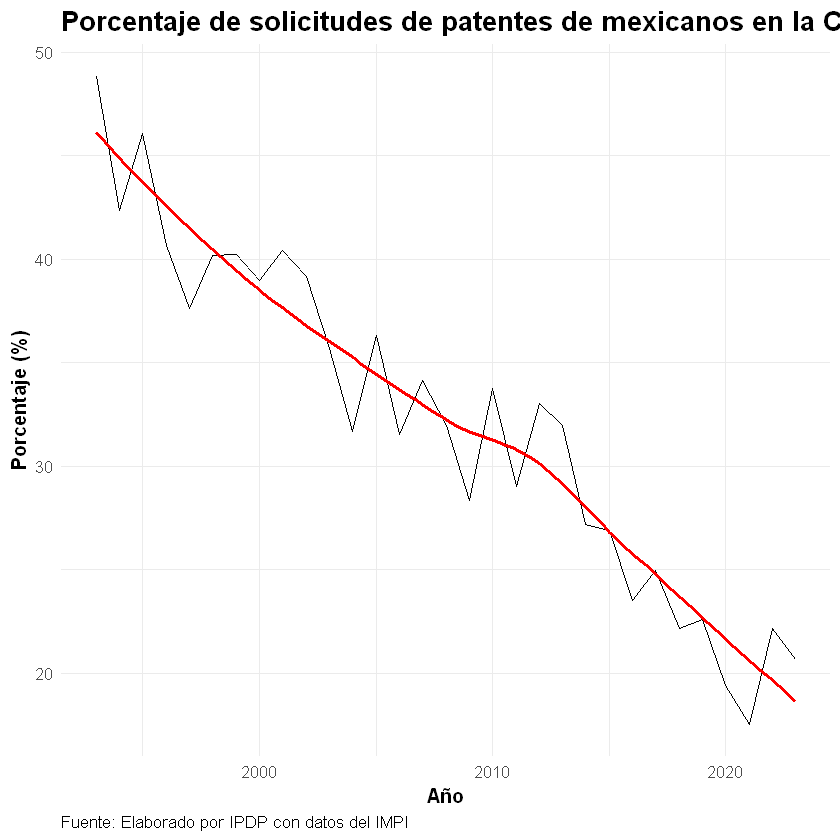

In [138]:
#Crear gráfica
ggplot(impi, aes(x = year, y = porcentaje)) +
  geom_line() +
  geom_smooth(method = "loess", se = FALSE, color = "red") +
  labs(title = "Porcentaje de solicitudes de patentes de mexicanos en la Ciudad de México respecto del total",
       x = "Año",
       y = "Porcentaje (%)",
       caption = "Fuente: Elaborado por IPDP con datos del IMPI") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0, size = 16, face = "bold"),
        plot.caption = element_text(hjust = 0, size = 10),
        axis.title = element_text(size = 12, face = "bold"),
        axis.text = element_text(size = 10),
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 10),
        legend.position = "none")

#Salvar gráfica
ggsave("porcentaje_patentes.png", width = 10, height = 6, dpi = 300, bg = "white")